# Probabilistic Deep Learning - Maximum likelihood

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Note: The code appears to be quite sensitive to library versions

In [5]:
tf.__version__

'2.3.2'

In [6]:
tfp.__version__

'0.11.1'

### Linear regression

#### Generate data

In [7]:
np.random.seed(42)
a = 3
b = 2
n = 1000
x = np.linspace(0, 10, n)
y = np.random.normal(a*x + b, 
                     np.repeat([1,4,2,8,1], n//5))

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=1)

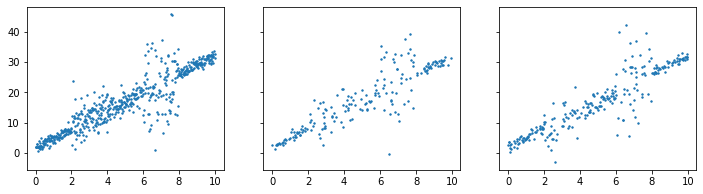

In [9]:
fig, axes = plt.subplots(1,3,figsize=(12,3), sharey=True)
axes[0].scatter(x_train, y_train, s=2)
axes[1].scatter(x_val, y_val, s=2)
axes[2].scatter(x_test, y_test, s=2)
pass

#### Construct model

In [10]:
def nll(x, dist):
    """Negative log likelilhood."""
    
    return -dist.log_prob(x)

def get_dist(params, eps=1e-3):
    """Construct a distribution."""
    
    return tfd.Normal(
        loc = params[:, 0:1],
        scale = eps + params[:, 1:2]
    )

#### Model notes

Model with complicated variation structure. 

This example illustrates the flexibility of the functional interface - we want $\sigma$ to be flexible to model variance that changes with the mean flexibly, but $\mu$ is still a linear regression and hence must be a simple linear function of the inputs directly.

In [11]:
inputs = Input(shape=(1,))
μ = Dense(1)(inputs)
hidden = Dense(30, activation='relu')(inputs)
hidden = Dense(20, activation='relu')(hidden)
hidden = Dense(20, activation='relu')(hidden)
σ = tf.math.softplus(Dense(1)(hidden))
params = Concatenate()([μ, σ])
dist = tfp.layers.DistributionLambda(get_dist)(params)

model = Model(inputs=inputs, outputs=dist)
model.compile(Adam(lr=0.01), loss=nll)

#### Fit model

In [12]:
runs = 5000
history = model.fit(x_train, y_train,
                    epochs=runs, verbose=0,
                    validation_data=(x_val, y_val))

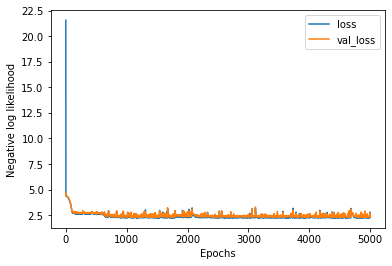

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('Negative log likelihood')
plt.xlabel('Epochs')
pass

#### Visualize model predictions

In [14]:
model_μ = Model(inputs=inputs, outputs=dist.mean())
model_σ = Model(inputs=inputs, outputs=dist.stddev())

In [15]:
xp = np.linspace(0, 10, 100)
yp = model_μ.predict(xp)

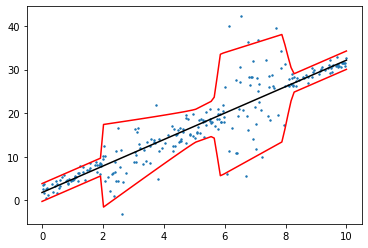

In [16]:
plt.scatter(x_test, y_test, s=2)
plt.plot(xp, yp, 'k')
plt.plot(xp, yp + 2*model_σ.predict(xp), 'r')
plt.plot(xp, yp - 2*model_σ.predict(xp), 'r')
pass

#### Extrapolation reveals problems with this model

The model seems strangely confident about regions where it has never seen data!

In [17]:
xp = np.linspace(-2, 12, 100)
yp = model_μ.predict(xp)

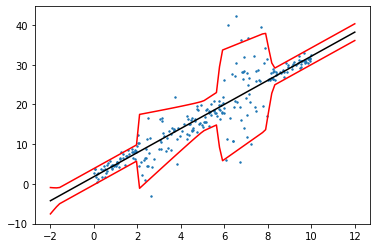

In [18]:
plt.scatter(x_test, y_test, s=2)
plt.plot(xp, yp, 'k')
plt.plot(xp, yp + 2*model_σ.predict(xp), 'r')
plt.plot(xp, yp - 2*model_σ.predict(xp), 'r')
pass